In [ ]:
# Modified from https://rumn.medium.com/custom-pytorch-image-classifier-from-scratch-d7b3c50f9fbe
# To run locally, install the following packages
#!pip install --quiet torch numpy pandas scikit-learn pillow torchvision

In [ ]:
# In addition, you will have to resize the images and store them in a separate folder (not included in the repo)
# from PIL import Image 
# import glob
# import os

# paths = glob.glob("./images/*/*.jpg")
# countries = set()
# for path in paths:
#    substr = path[9:]
#    country_name = substr[:substr.find('/')]
#    if not os.path.exists(f"./enetb0_images/{country_name}"):
#       os.makedirs(f"./enet_images/{country_name}")

# for path in glob.glob("./images/*/*.jpg"):
#    image_file = Image.open(path) 
#    new_image = image_file.resize((256, 224)) # image must be in this size for EfficientNet_b0. Larger models may encounter issues with GPU RAM
#    new_path = f'./enetb0_images/{path[9:]}'
#    new_image.save(new_path)
#
# If you want to run this in collab, make a zip file, upload it, and use
# !unzip enetb0_images.zip
# !ls

# Fine-tuning EfficientNet for Geoguessr
There are a lot of strong classifier models for computer vision, which could be well suited for this task. This notebook fine-tunes EfficiencyNet_b0.

In [3]:
import torch
import torchvision

In [4]:
model = torchvision.models.efficientnet_b0()
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import glob
from tqdm import tqdm

image_path_list = []
label_list = []

for path in glob.glob("./e_net_b0_images/*/*.jpg"):
   substr = path[len('./e_net_b0_images')+1:]
   label = substr[:substr.find('/')]
   image_path_list.append(path)
   label_list.append(label)

df = pd.DataFrame()
df["image_path"] = image_path_list
df["label"] = label_list

df

,image_path,label
0,./e_net_b0_images/Uganda/canvas_1630110574.jpg,Uganda
1,./e_net_b0_images/Uganda/canvas_1629748954.jpg,Uganda
2,./e_net_b0_images/Uganda/canvas_1629766624.jpg,Uganda
3,./e_net_b0_images/Uganda/canvas_1629441091.jpg,Uganda
4,./e_net_b0_images/Uganda/canvas_1629269512.jpg,Uganda
...,...,...
4994,./e_net_b0_images/Italy/canvas_1629324260.jpg,Italy
4995,./e_net_b0_images/Italy/canvas_1629411605.jpg,Italy
4996,./e_net_b0_images/Italy/canvas_1629283408.jpg,Italy
4997,./e_net_b0_images/Italy/canvas_1629822756.jpg,Italy


In [6]:
for country in set(df["label"]):
   if len(df[df.label == country]) < 2:
      df = df.drop(df[df.label == country].index)
      # number of data per label cannot be less than 2 (requirement for scikit train_test_split)
      # this means that some countries like Andorra will never be guessed

In [7]:
# split dataset into train and test
test_ratio = 0.2

train_df, test_df = train_test_split(df, test_size=test_ratio,
                                     stratify=df['label'], random_state = 0)

print(f"Original dataset shape: {df.shape}")
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

Original dataset shape: (4989, 2)
Train dataset shape: (3991, 2)
Test dataset shape: (998, 2)


In [8]:
# Data Augmentation

# this will be used during training, this will hold all the augmentation/transformation configs
training_transform = transforms.Compose([transforms.Resize((256, 224)),
                                            transforms.RandomHorizontalFlip(p=0.5),
                                             transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# this will be used during testing / infernece, wo don't want any kind of additional transformation applied at the time of running model prediction in test / production inviroment
test_transform = transforms.Compose([transforms.Resize((256, 224)),
                                             transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [9]:
# load images
class GeoguessrData(Dataset):
   def __init__(self, csv_df, class_list, transform=None):
      self.df = csv_df
      self.transform = transform
      self.class_list = class_list

   def __len__(self):
      return self.df.shape[0]

   def __getitem__(self, index):
      image = Image.open(self.df.iloc[index].image_path).convert('RGB')
      label = self.class_list.index(self.df.iloc[index].label)

      if self.transform:
         image = self.transform(image)

      return image, label

In [10]:
CLASS_LIST = list(set(label_list))
train_data_object = GeoguessrData(train_df, CLASS_LIST, training_transform)
test_data_object = GeoguessrData(test_df, CLASS_LIST, test_transform)

In [11]:
# Dataloader
BATCH_SIZE = 32
# now define dataloader, this will load the images batches from CustomTrainingData object
train_loader = DataLoader(train_data_object, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data_object, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [12]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.001
NUM_CLASSES = len(CLASS_LIST)
INPUT_SIZE = (256, 224)
CHANNELS = 3

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
import gc
torch.cuda.empty_cache() # There can be memory issues for larger models
gc.collect()

25

In [ ]:
# Initialize model
model = torchvision.models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT").to(device)
model.classifier[1] = nn.Linear(in_features=1280, out_features=NUM_CLASSES).to(device)

In [15]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}") # 4M

Total number of parameters: 4135648


In [16]:
# Training loop
for epoch in tqdm(range(EPOCHS)):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = 100 * sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Epoch [{epoch+1}/{EPOCHS}]')
    print(f'Accuracy on test set: {accuracy:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('-----------------------------')

print('Training finished!')

# Save the model
torch.save(model.state_dict(), 'model/enet/Geoguessr_classifier.pt')


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25], Loss: 3.0672


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|▍         | 1/25 [00:29<11:47, 29.47s/it]

Epoch [1/25]
Accuracy on test set: 37.07%
Precision: 0.2494
Recall: 0.3707
F1 Score: 0.2700
-----------------------------
Epoch [2/25], Loss: 2.3264


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|▊         | 2/25 [00:59<11:22, 29.69s/it]

Epoch [2/25]
Accuracy on test set: 39.78%
Precision: 0.3549
Recall: 0.3978
F1 Score: 0.3457
-----------------------------
Epoch [3/25], Loss: 1.8618


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|█▏        | 3/25 [01:30<11:10, 30.49s/it]

Epoch [3/25]
Accuracy on test set: 42.38%
Precision: 0.3507
Recall: 0.4238
F1 Score: 0.3689
-----------------------------
Epoch [4/25], Loss: 1.4256


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 16%|█▌        | 4/25 [02:02<10:48, 30.90s/it]

Epoch [4/25]
Accuracy on test set: 43.49%
Precision: 0.4057
Recall: 0.4349
F1 Score: 0.3879
-----------------------------
Epoch [5/25], Loss: 1.0773


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 20%|██        | 5/25 [02:33<10:23, 31.19s/it]

Epoch [5/25]
Accuracy on test set: 43.59%
Precision: 0.4173
Recall: 0.4359
F1 Score: 0.4075
-----------------------------
Epoch [6/25], Loss: 0.8067


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 24%|██▍       | 6/25 [03:05<09:56, 31.37s/it]

Epoch [6/25]
Accuracy on test set: 44.69%
Precision: 0.4085
Recall: 0.4469
F1 Score: 0.4164
-----------------------------
Epoch [7/25], Loss: 0.5916


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 28%|██▊       | 7/25 [03:36<09:23, 31.30s/it]

Epoch [7/25]
Accuracy on test set: 41.48%
Precision: 0.4749
Recall: 0.4148
F1 Score: 0.4275
-----------------------------
Epoch [8/25], Loss: 0.4037


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 32%|███▏      | 8/25 [04:06<08:44, 30.87s/it]

Epoch [8/25]
Accuracy on test set: 43.99%
Precision: 0.4373
Recall: 0.4399
F1 Score: 0.4242
-----------------------------
Epoch [9/25], Loss: 0.2982


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 36%|███▌      | 9/25 [04:37<08:12, 30.75s/it]

Epoch [9/25]
Accuracy on test set: 45.99%
Precision: 0.4228
Recall: 0.4599
F1 Score: 0.4296
-----------------------------
Epoch [10/25], Loss: 0.2229


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 40%|████      | 10/25 [05:08<07:44, 30.93s/it]

Epoch [10/25]
Accuracy on test set: 40.18%
Precision: 0.4191
Recall: 0.4018
F1 Score: 0.3950
-----------------------------
Epoch [11/25], Loss: 0.1920


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 44%|████▍     | 11/25 [05:39<07:12, 30.91s/it]

Epoch [11/25]
Accuracy on test set: 45.09%
Precision: 0.4440
Recall: 0.4509
F1 Score: 0.4326
-----------------------------
Epoch [12/25], Loss: 0.1797


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 48%|████▊     | 12/25 [06:10<06:40, 30.81s/it]

Epoch [12/25]
Accuracy on test set: 43.99%
Precision: 0.4175
Recall: 0.4399
F1 Score: 0.4186
-----------------------------
Epoch [13/25], Loss: 0.1984


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 52%|█████▏    | 13/25 [06:41<06:10, 30.88s/it]

Epoch [13/25]
Accuracy on test set: 41.58%
Precision: 0.3918
Recall: 0.4158
F1 Score: 0.3869
-----------------------------
Epoch [14/25], Loss: 0.1946


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 56%|█████▌    | 14/25 [07:11<05:37, 30.72s/it]

Epoch [14/25]
Accuracy on test set: 45.49%
Precision: 0.4174
Recall: 0.4549
F1 Score: 0.4260
-----------------------------
Epoch [15/25], Loss: 0.1911


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 60%|██████    | 15/25 [07:42<05:07, 30.70s/it]

Epoch [15/25]
Accuracy on test set: 42.08%
Precision: 0.3982
Recall: 0.4208
F1 Score: 0.3930
-----------------------------
Epoch [16/25], Loss: 0.1678


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 64%|██████▍   | 16/25 [08:11<04:33, 30.37s/it]

Epoch [16/25]
Accuracy on test set: 42.99%
Precision: 0.4213
Recall: 0.4299
F1 Score: 0.4120
-----------------------------
Epoch [17/25], Loss: 0.1660


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 68%|██████▊   | 17/25 [08:41<04:00, 30.05s/it]

Epoch [17/25]
Accuracy on test set: 42.69%
Precision: 0.4622
Recall: 0.4269
F1 Score: 0.4157
-----------------------------
Epoch [18/25], Loss: 0.1609


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 72%|███████▏  | 18/25 [09:10<03:28, 29.82s/it]

Epoch [18/25]
Accuracy on test set: 46.19%
Precision: 0.4406
Recall: 0.4619
F1 Score: 0.4358
-----------------------------
Epoch [19/25], Loss: 0.1090


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 76%|███████▌  | 19/25 [09:41<03:00, 30.08s/it]

Epoch [19/25]
Accuracy on test set: 45.49%
Precision: 0.4237
Recall: 0.4549
F1 Score: 0.4303
-----------------------------
Epoch [20/25], Loss: 0.0851


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 80%|████████  | 20/25 [10:11<02:30, 30.16s/it]

Epoch [20/25]
Accuracy on test set: 43.39%
Precision: 0.4462
Recall: 0.4339
F1 Score: 0.4268
-----------------------------
Epoch [21/25], Loss: 0.1160


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 84%|████████▍ | 21/25 [10:41<02:00, 30.10s/it]

Epoch [21/25]
Accuracy on test set: 40.18%
Precision: 0.4184
Recall: 0.4018
F1 Score: 0.3886
-----------------------------
Epoch [22/25], Loss: 0.2007


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 88%|████████▊ | 22/25 [11:12<01:31, 30.41s/it]

Epoch [22/25]
Accuracy on test set: 42.48%
Precision: 0.4264
Recall: 0.4248
F1 Score: 0.4120
-----------------------------
Epoch [23/25], Loss: 0.1506


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 92%|█████████▏| 23/25 [11:43<01:00, 30.49s/it]

Epoch [23/25]
Accuracy on test set: 44.19%
Precision: 0.3975
Recall: 0.4419
F1 Score: 0.4123
-----------------------------
Epoch [24/25], Loss: 0.1798


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 96%|█████████▌| 24/25 [12:14<00:30, 30.60s/it]

Epoch [24/25]
Accuracy on test set: 41.58%
Precision: 0.4198
Recall: 0.4158
F1 Score: 0.4070
-----------------------------
Epoch [25/25], Loss: 0.1352


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 25/25 [12:44<00:00, 30.60s/it]

Epoch [25/25]
Accuracy on test set: 42.69%
Precision: 0.4262
Recall: 0.4269
F1 Score: 0.4196
-----------------------------
Training finished!


# Results
It appears that the final test accuracy was 42.69%, which is lower than our Multimodal LLMs. 

We have only trained it for 25 epochs, and so I have fine-tuned the best performing one for 24-hours on a Google Cloud Deep Learning VM server for comparison.
See the results in the README file.


In [17]:
# Inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_SIZE = (256, 224)
CHANNELS = 3

new_model = torchvision.models.efficientnet_b0(weights=None).to(device)
new_model.classifier[1] = nn.Linear(in_features=1280, out_features=NUM_CLASSES)

# Load the saved state dictionary
state_dict = torch.load('model/enet/Geoguessr_classifier.pt')
# Load the state dictionary into your model
new_model.load_state_dict(state_dict)
# Set the model to evaluation mode
new_model.to(device).eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [18]:
# this will be used during testing / infernece, wo don't want any kind of additional transformation applied at the time of running model prediction in test / production inviroment
test_transform = transforms.Compose([transforms.Resize(INPUT_SIZE),
                                             transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [19]:
def plot_image(image):
   """
   Plot an image using matplotlib.

   Parameters:
   image : PIL.Image or numpy.ndarray
      The image to be plotted. Can be a PIL Image object or a numpy array.
   """
   # Convert PIL Image to numpy array if necessary
   if isinstance(image, Image.Image):
      image = np.array(image)

   plt.imshow(image)

   plt.axis('off')  # Hide axes
   plt.show()

In [20]:
# Inference
def predict(model, image_path):
   image_pil = Image.open(image_path).convert('RGB')
   image = test_transform(image_pil).unsqueeze(0).to(device)

   with torch.no_grad():
      output = model(image)
      # Apply softmax to the output
      softmax_output = F.softmax(output, dim=1)

      print(f'Model raw output: {output}')
      print(f'Softmax output: {softmax_output}')

      # Get the predicted class and its confidence
      confidence, predicted = torch.max(softmax_output, 1)

      predicted_class = CLASS_LIST[predicted.item()]
      confidence = confidence.item()

   print(f'Predicted class: {predicted_class}')
   print(f'Confidence: {confidence:.4f}')
   plot_image(image_pil)

In [ ]:
import glob
import random

def get_random_image():
   """Return a dict of path image with its corresponding full country name
   args:
      None

   returns:
      dict with fields "country" and "image_path"
   """

   paths = glob.glob("./e_net_b0_images/*/*.jpg")
   image_path = random.choice(paths)
   # ex. ./e_net_b0_images/Argentina/canvas_1629303518.jpg
   substr = path[len('./e_net_b0_images')+1:]
   country_name = substr[:substr.find('/')]
   
   return {"country": country_name, "image_path": image_path}

Image from: Costa Rica
Model raw output: tensor([[ -6.4061,   6.0067,  -9.5216, -14.4202, -17.2030,   5.4600, -14.9960,
          -2.1860, -19.9009, -11.3963, -11.3852, -17.2364, -18.2722,  -6.7090,
         -18.6108, -20.2567, -12.2705, -19.9731,   0.7964, -13.7786,  -6.3272,
         -15.0762, -12.5492,  -1.9426, -11.0013, -11.4918, -19.0503,  -9.9068,
         -21.5577,  -8.1399, -19.2151,  -7.5455, -12.3310, -16.9327, -19.9540,
          -6.8371, -15.2514,  -5.1700, -10.9246, -11.6607, -18.5071, -15.5092,
         -12.1249, -15.7751,  -5.4473,  -9.8915,  -7.7729,   7.2744,  -2.9686,
         -15.9820,  -9.9312,  -2.2524,  -2.8229,  -3.5381, -17.6616, -15.0701,
         -14.8855,  -5.3925,  -0.1438,  -1.9763, -22.7303,  -4.6415, -15.5590,
         -14.1046, -13.8665, -20.1749,  -9.2984, -19.6534, -28.3507,  -9.4596,
         -12.4296, -15.4818,  -9.0176, -15.4518,  -8.6262, -14.1403, -13.9627,
         -15.9884, -17.3921, -18.1408, -11.5546,  -8.7172, -20.2345,  -1.6051,
         -1

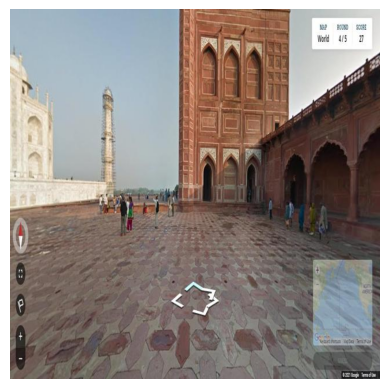

In [29]:
from IPython.display import Image as notebookImage

image = get_random_image()
print("Image from:", image["country"])
notebookImage(filename=image["image_path"])

predict(new_model, image["image_path"])